In [1]:
import wandb, os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from transformers import TrainingArguments
wandb.login()

wandb_project = "jokes-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dhruvin1111. Use `wandb login --relogin` to force relogin


In [2]:
device_count = torch.cuda.device_count()
if device_count > 0:
    print("Select GPU device")
    device = torch.device("cuda")
else:
    print("Select CPU device")
    device = torch.device("cpu")

Select GPU device


In [3]:
base_model_id = "EleutherAI/pythia-14m"

In [4]:
train_dataset = load_dataset('json', data_files='./data/reddit_jokes.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='./data/reddit_jokes_validation.jsonl', split='train')

In [5]:
def formatting_func(example):
    text = f"### The following is the joke title: {example['title']} \n ### joke: {example['body']}"
    return text

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/106393 [00:00<?, ? examples/s]

Map:   0%|          | 0/26599 [00:00<?, ? examples/s]

132992


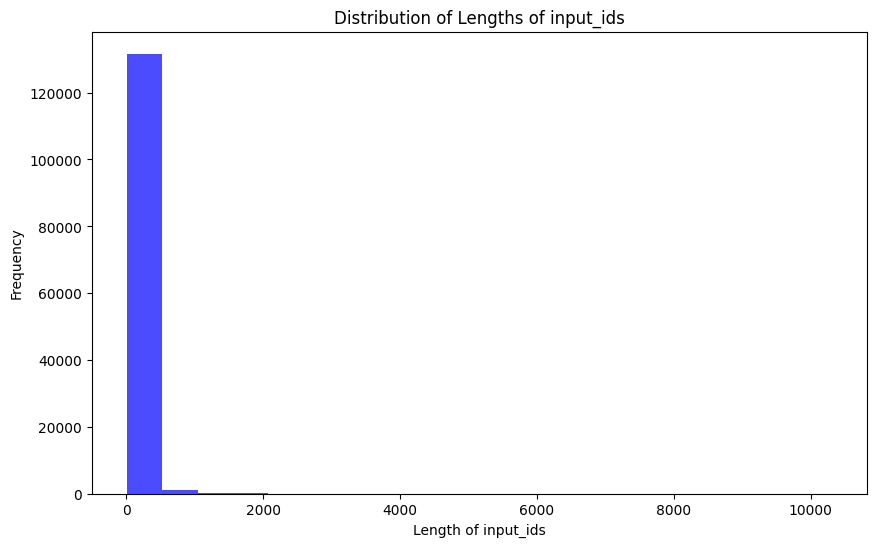

In [8]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [9]:
max_length = 1024 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/106393 [00:00<?, ? examples/s]

Map:   0%|          | 0/26599 [00:00<?, ? examples/s]

In [11]:
print(tokenized_train_dataset[1]['input_ids'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

132992


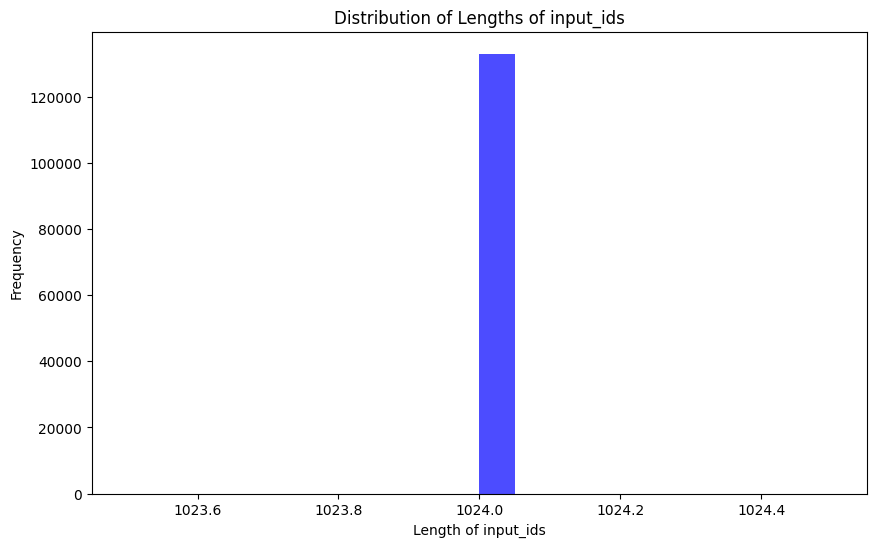

In [12]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)


### How does the base model do?

In [13]:
#model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.float16)
base_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 128)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=128, out_features=384, bias=True)
          (dense): Linear(in_features=128, out_features=128, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=128, out_features=512, bias=True)
          (dense_4h_to_h): Linear(in_features=512, out_features=128, bias=True)
          (act)

In [14]:
eval_prompt = "### The following is the joke title: The apple \n ### joke:"
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

base_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(base_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


### The following is the joke title: The apple 
 ### joke:
  "The first one of "the second two." I'm not sure if it's a good thing, but that you can't be. It was like this! (I don’t know what to do with them) and they are all right; in my opinion we have no idea how much else would happen.)




In [15]:
trained_model_name = f"joke_llm"
output_dir = trained_model_name

In [16]:
import transformers
from datetime import datetime

trainer = transformers.Trainer(
    model=base_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        #num_train_epochs=1,
        max_steps = 10000,
        learning_rate=1e-5, # Want a small lr for finetuning
        logging_steps=5000,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=5000,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=5000,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{trained_model_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
)

base_model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: dad_joke_llm/final


In [18]:
finetuned_model = AutoModelForCausalLM.from_pretrained('./joke_llm/checkpoint-5000', local_files_only=True)
finetuned_model.to(device) 

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 128)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=128, out_features=384, bias=True)
          (dense): Linear(in_features=128, out_features=128, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=128, out_features=512, bias=True)
          (dense_4h_to_h): Linear(in_features=512, out_features=128, bias=True)
          (act)

In [19]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

finetuned_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(finetuned_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Finetuned slightly model's answer: 



In [20]:
print("Model's answer: ")
print(inference("### The following is the joke title: The apple \n ### joke:", base_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Model's answer: 

